In [29]:
# load spatialte database
import os
import sqlite3

conn = sqlite3.connect("addresses.db")
conn.enable_load_extension(True)
conn.load_extension(os.environ.get("SPATIALITE_EXTENSION", "/usr/lib/x86_64-linux-gnu/mod_spatialite.so"))
c = conn.cursor()

In [3]:
# number of UPRNs
c.execute("SELECT count(*) FROM uprn")
uprn_total = c.fetchone()[0]
print(f"{uprn_total:,}")

39,095,248


In [4]:
# number of postcodes
c.execute("SELECT count(*) FROM postcode")
postcode_total = c.fetchone()[0]
print(f"{postcode_total:,}")

2,643,728


In [5]:
# postcodes with the most number of UPRNs ..
c.execute("""
SELECT postcode, count(*)
FROM uprn
GROUP BY postcode
ORDER BY count(*) DESC
LIMIT 50
""")
c.fetchall()

[('CV4 7ES', 6276),
 ('NR4 7TJ', 4725),
 ('CO4 3SQ', 3303),
 ('SA1 8EP', 2044),
 ('HG3 5JL', 1570),
 ('PO20 9BH', 1546),
 ('CF14 3UU', 1496),
 ('YO25 8SY', 1478),
 ('DL8 4AT', 1476),
 ('CF37 1DL', 1468),
 ('LE11 3TZ', 1442),
 ('LS16 5PT', 1287),
 ('BN1 9BJ', 1280),
 ('CV4 7AL', 1273),
 ('L3 5UE', 1268),
 ('UB8 3PH', 1216),
 ('CF14 3UX', 1164),
 ('L6 1AH', 1159),
 ('YO15 3QN', 1151),
 ('BN1 9RJ', 1148),
 ('LS2 8PD', 1146),
 ('PE25 1LX', 1142),
 ('M14 6FZ', 1123),
 ('WC1H 9EN', 1106),
 ('BN1 9RP', 1087),
 ('IV27 4NZ', 1066),
 ('AL10 9UF', 1043),
 ('E14 9GE', 1034),
 ('E14 7TZ', 1020),
 ('NN1 5PH', 1011),
 ('OX3 0BD', 999),
 ('LS2 9EL', 988),
 ('CW1 5NP', 977),
 ('AL10 9UZ', 977),
 ('L3 5GA', 965),
 ('B4 7XG', 950),
 ('E1 7AB', 934),
 ('SW17 0PZ', 933),
 ('LS18 5HD', 932),
 ('LN4 4LR', 925),
 ('CT2 7BQ', 909),
 ('HU6 7EL', 908),
 ('LS2 8BY', 907),
 ('G3 8PX', 895),
 ('L6 1BA', 891),
 ('CO2 8GY', 891),
 ('SS8 0DB', 877),
 ('KT6 5PJ', 864),
 ('WC1H 0AQ', 863),
 ('E15 2DA', 863)]

In [27]:
# number of UPRNs where ONSUD and ONSPD differ
c.execute("""
SELECT
  COUNT(*)
  FROM uprn
  INNER JOIN postcode
  ON postcode.postcode = uprn.postcode
  WHERE uprn.onsud != postcode.onspd
""")
onsud_onspd_differ = c.fetchone()[0]
print(f"{onsud_onspd_differ:,}")

393,693


In [28]:
# percentage of GB UPRNs where ONSUD and ONSPD differ
print("%2.1f%%" % (onsud_onspd_differ / uprn_total * 100))

1.0%


In [20]:
# number of UPRNs in an English ONSPD postcode
c.execute("""
SELECT
  COUNT(*)
  FROM uprn
  INNER JOIN postcode
  ON postcode.postcode = uprn.postcode
  WHERE substr(onsud, 1, 1) == 'E'
""")
england_uprn_total = c.fetchone()[0]
print(f"{england_uprn_total:,}")

33,427,350


In [23]:
# number of UPRNs in an English ONSPD postcode where ONSUD and ONSPD differ
c.execute("""
SELECT
  COUNT(*)
  FROM uprn
  INNER JOIN postcode
  ON postcode.postcode = uprn.postcode
  WHERE substr(uprn.onsud, 1, 1) == 'E'
    AND uprn.onsud != postcode.onspd
""")
england_onsud_onspd_differ = c.fetchone()[0]
print(f"{england_onsud_onspd_differ:,}")

386,103


In [25]:
# percentage of English UPRNs where ONSUD and ONSPD differ
print("%2.1f%%" % (england_onsud_onspd_differ / england_uprn_total * 100))

1.2%


In [10]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import array

In [11]:
# postcodes with UPRNs which are attributed to different LAs by ONSUD
c.execute("""
SELECT COUNT(DISTINCT onsud) count, postcode
  FROM uprn
  GROUP BY postcode
  ORDER BY count DESC
""")

def dict_from_fetch(l):
    d = dict()
    for a, b in l:
        d.setdefault(a, [])
        d[a].append(b)
    return d

postcode_lad_count = dict_from_fetch(c.fetchall())
postcode_lad_counts = array([(n, len(postcode_lad_count[n])) for n in sorted(postcode_lad_count)])
print(postcode_lad_counts)

[[      1 1698266]
 [      2   15992]
 [      3     227]
 [      4       1]]


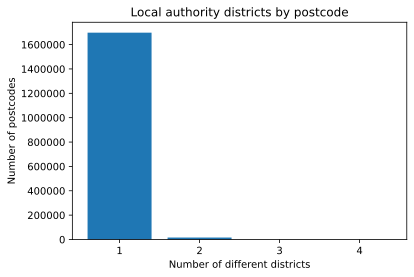

In [12]:
fig, ax = plt.subplots()
data = array(postcode_lad_counts)
ax.set_title('Local authority districts by postcode')
ax.set_xlabel("Number of different districts")
ax.set_ylabel("Number of postcodes")
x = data[:, :-1].flatten()
y = data[:, -1]
plt.xticks( x )
ax.ticklabel_format(style='plain')
p = plt.bar(x, y)

In [13]:
# postcodes with 3 or 4 multiple local authority districts
print([(n, postcode_lad_count[n]) for n in sorted(postcode_lad_count, reverse=True) if n > 2])

[(4, ['BN15 0AY']), (3, ['YO32 5TP', 'YO23 3PA', 'WV15 6HS', 'WV14 8TU', 'WV14 8NH', 'WS15 3NW', 'WS12 4PT', 'WR5 3HR', 'WF8 3JF', 'WF2 0SB', 'WD3 9YD', 'WD25 8PZ', 'WD19 4BE', 'WC2A 2LL', 'WA4 4EB', 'WA3 5LH', 'UB5 4DT', 'TS8 9DY', 'TS21 1LX', 'TS2 1UB', 'TQ9 6QB', 'TQ3 1SY', 'TN3 8JH', 'TN27 9JE', 'TN27 8LD', 'TN25 5JF', 'TN16 2NS', 'TF9 2SH', 'TF10 8DS', 'TA7 9BN', 'TA20 3RU', 'SY20 9LD', 'SY13 4HB', 'SW15 3QF', 'SW15 1LB', 'ST7 3PX', 'ST7 3PG', 'ST3 6HJ', 'ST10 4PF', 'SS8 0PY', 'SS8 0PS', 'SS6 7UA', 'SS11 8SG', 'SP5 5RA', 'SO40 3QS', 'SO16 3DQ', 'SN8 2JX', 'SN6 6JZ', 'SL6 0JA', 'SK17 0TG', 'SG9 0BH', 'SG7 5JH', 'SE12 9EZ', 'SA9 2XH', 'SA8 4RU', 'S80 3DZ', 'S6 6GL', 'S44 6AE', 'S36 4HH', 'S21 3UB', 'S17 3BB', 'S10 4QZ', 'RM14 3PB', 'RH6 9ST', 'RH6 0EL', 'RH5 6NS', 'RH19 3PR', 'RH12 3BE', 'RH12 3AP', 'RG7 2BG', 'RG2 6GF', 'RG2 6AT', 'PR4 1UN', 'PR3 1UT', 'PO16 9DR', 'PL20 6SG', 'PL15 9QX', 'PH22 1RB', 'PH15 2PX', 'PE6 7QB', 'PE13 5RF', 'PA36 4AG', 'OX29 4DE', 'OX15 5BX', 'OL3 5UN', '

In [78]:
# postcodes with UPRNs attributed to 3 or more LAs by ONSUD
c.execute("""
SELECT postcode, lad_count, uprn_count
FROM (SELECT postcode, COUNT(DISTINCT onsud) lad_count, COUNT(uprn) uprn_count
  FROM uprn
   GROUP BY postcode
    ORDER BY lad_count DESC)
     WHERE lad_count > 2
""")
postcodes = c.fetchall()
print(postcodes)

[('BN15 0AY', 4, 43), ('YO32 5TP', 3, 67), ('YO23 3PA', 3, 56), ('WV15 6HS', 3, 25), ('WV14 8TU', 3, 65), ('WV14 8NH', 3, 10), ('WS15 3NW', 3, 19), ('WS12 4PT', 3, 16), ('WR5 3HR', 3, 55), ('WF8 3JF', 3, 37), ('WF2 0SB', 3, 18), ('WD3 9YD', 3, 12), ('WD25 8PZ', 3, 20), ('WD19 4BE', 3, 25), ('WC2A 2LL', 3, 11), ('WA4 4EB', 3, 8), ('WA3 5LH', 3, 11), ('UB5 4DT', 3, 83), ('TS8 9DY', 3, 20), ('TS21 1LX', 3, 24), ('TS2 1UB', 3, 569), ('TQ9 6QB', 3, 31), ('TQ3 1SY', 3, 19), ('TN3 8JH', 3, 28), ('TN27 9JE', 3, 32), ('TN27 8LD', 3, 42), ('TN25 5JF', 3, 11), ('TN16 2NS', 3, 12), ('TF9 2SH', 3, 27), ('TF10 8DS', 3, 24), ('TA7 9BN', 3, 23), ('TA20 3RU', 3, 16), ('SY20 9LD', 3, 57), ('SY13 4HB', 3, 30), ('SW15 3QF', 3, 17), ('SW15 1LB', 3, 65), ('ST7 3PX', 3, 11), ('ST7 3PG', 3, 4), ('ST3 6HJ', 3, 25), ('ST10 4PF', 3, 35), ('SS8 0PY', 3, 172), ('SS8 0PS', 3, 69), ('SS6 7UA', 3, 36), ('SS11 8SG', 3, 16), ('SP5 5RA', 3, 18), ('SO40 3QS', 3, 38), ('SO16 3DQ', 3, 21), ('SN8 2JX', 3, 21), ('SN6 6JZ', 3

In [70]:
# postcodes where ONSUD UPRNs span multiple nations
c.execute("""
SELECT postcode
FROM (SELECT
    postcode,  COUNT(DISTINCT substr(onsud, 1, 1)) count
    FROM uprn
    GROUP BY postcode
    ORDER BY count DESC)
  WHERE count > 1
""")
postcodes = list(array(c.fetchall()).flatten())
print(len(postcodes))
print(postcodes)

286
['TD9 0TW', 'TD9 0TU', 'TD9 0SR', 'TD9 0SL', 'TD8 6PS', 'TD8 6NL', 'TD8 6NJ', 'TD5 8QA', 'TD5 8PT', 'TD5 8HT', 'TD5 8DB', 'TD5 8DA', 'TD5 8BZ', 'TD5 8BP', 'TD5 8AR', 'TD15 2XN', 'TD15 1XB', 'TD15 1UZ', 'TD15 1UY', 'TD15 1UT', 'TD15 1UF', 'TD15 1SZ', 'TD15 1SU', 'TD12 4RS', 'TD12 4RR', 'TD12 4NT', 'TD12 4LF', 'TD12 4AT', 'SY9 5JW', 'SY9 5JR', 'SY9 5JP', 'SY9 5JN', 'SY9 5JL', 'SY9 5HQ', 'SY7 8QX', 'SY7 8PR', 'SY7 8PP', 'SY7 0BA', 'SY5 9RZ', 'SY5 9PE', 'SY5 9DP', 'SY5 9BW', 'SY5 9AW', 'SY5 9AT', 'SY5 9AN', 'SY5 0JW', 'SY5 0JP', 'SY5 0JN', 'SY5 0JL', 'SY5 0JJ', 'SY5 0JH', 'SY4 5NN', 'SY22 6TW', 'SY22 6TN', 'SY22 6SH', 'SY22 6QY', 'SY22 6LQ', 'SY22 6LN', 'SY22 6LH', 'SY22 6JZ', 'SY22 6JY', 'SY22 6HB', 'SY22 6EL', 'SY22 6EJ', 'SY22 6EA', 'SY22 6BA', 'SY21 8JZ', 'SY21 8JY', 'SY21 8JL', 'SY21 8JB', 'SY21 8JA', 'SY21 8ES', 'SY21 8ER', 'SY21 8EN', 'SY21 8EG', 'SY15 6UL', 'SY15 6UB', 'SY15 6TZ', 'SY15 6TY', 'SY15 6TW', 'SY15 6TR', 'SY15 6SY', 'SY15 6SR', 'SY15 6SP', 'SY15 6HZ', 'SY15 6HY', 'S

In [47]:
# number of UPRNs which ONSUD says are in England, but the ONSPD LAD is in another nation
c.execute("""
SELECT COUNT(*) FROM uprn
  INNER JOIN postcode
  ON postcode.postcode = uprn.postcode
  WHERE substr(uprn.onsud, 1, 1) != 'E' 
  AND substr(postcode.onspd, 1, 1) == 'E'
""")
c.fetchone()[0]

609

In [48]:
# number of UPRNs which the ONSPD LAD is in England, but ONSUD says are in another nation 
c.execute("""
SELECT COUNT(*) FROM uprn
  INNER JOIN postcode
  ON postcode.postcode = uprn.postcode
  WHERE substr(uprn.onsud, 1, 1) == 'E' 
  AND substr(postcode.onspd, 1, 1) != 'E'
""")
c.fetchone()[0]

609

In [77]:
c.execute("""
SELECT postcode FROM postcode
WHERE postcode.nspl != postcode.onspd
""")
postcodes = list(array(c.fetchall()).flatten())
print(len(postcodes))
print(postcodes)

215
['AL4 0QL', 'BL9 8RH', 'BT17 0BU', 'BT17 0EZ', 'BT17 0FE', 'BT17 0LL', 'BT17 0LP', 'BT17 0LR', 'BT17 0LW', 'BT17 0NS', 'BT17 0NT', 'BT17 0QL', 'BT17 0YU', 'BT25 2DB', 'BT25 2DD', 'BT25 2DZ', 'BT25 2EA', 'BT25 2EE', 'BT25 2EG', 'BT25 2EQ', 'BT25 2EW', 'BT25 2HJ', 'BT25 2HL', 'BT25 2HQ', 'BT25 2HR', 'BT25 2HW', 'BT25 2LG', 'BT29 4LH', 'BT31 9PT', 'BT31 9PX', 'BT31 9PZ', 'BT31 9QD', 'BT31 9QE', 'BT31 9QX', 'BT31 9QY', 'BT31 9QZ', 'BT31 9RE', 'BT31 9RS', 'BT31 9SA', 'BT31 9SB', 'BT32 5HD', 'BT38 8BA', 'BT38 8UY', 'BT38 8XA', 'BT38 8YG', 'BT38 8ZQ', 'BT38 8ZR', 'BT38 8ZS', 'BT5 7QD', 'BT5 7QZ', 'BT5 7ST', 'BT5 7SU', 'BT5 7SX', 'BT5 7TA', 'BT5 7TS', 'BT5 7TT', 'BT5 7TX', 'BT5 7TZ', 'BT6 0NJ', 'BT6 0PA', 'BT67 0UA', 'BT71 6LX', 'BT71 6LY', 'BT71 6LZ', 'BT71 6NR', 'BT75 0NB', 'BT8 4AB', 'BT8 4AR', 'BT8 4AX', 'BT8 4BA', 'BT8 4BB', 'BT8 4BD', 'BT8 4BE', 'BT8 4BF', 'BT8 4BS', 'BT8 4DD', 'BT8 4EB', 'BT8 4ET', 'BT8 4EU', 'BT8 4EW', 'BT8 4EY', 'BT8 4EZ', 'BT8 4FJ', 'BT8 4FL', 'BT8 4FY', 'BT8 4FZ

In [49]:
# number of UPRNs where the ONSPD LAD differs to the NSPL LAD 
c.execute("""
SELECT COUNT(*) FROM uprn
INNER JOIN postcode
  ON postcode.postcode = uprn.postcode
  WHERE postcode.nspl != postcode.onspd
""")
c.fetchone()[0]

543

In [65]:
# postcodes where the OS codepo LAD differes to the ONSPD LAD 
c.execute("""
SELECT COUNT(*) FROM postcode
  WHERE postcode.codepo != postcode.onspd
""")
print('{:,}'.format(c.fetchone()[0]))

927,371


In [66]:
# number of UPRNs where the OS codepo LAD differs to the ONSPD LAD 
c.execute("""
SELECT COUNT(*) FROM uprn
INNER JOIN postcode
  ON postcode.postcode = uprn.postcode
  WHERE postcode.codepo != postcode.onspd
""")
print('{:,}'.format(c.fetchone()[0]))

155,529
